In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity


class HTRU1(data.Dataset):
    """`HTRU1 <https://as595.github.io/HTRU1/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``htru1-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """

    base_folder = 'htru1-batches-py'
    url = "http://www.jb.man.ac.uk/research/ascaife/htru1-batches-py.tar.gz"
    filename = "htru1-batches-py.tar.gz"
    tgz_md5 = 'e7b063301ada3eb50f212afeea185a36'
    train_list = [
                  ['data_batch_1', '3a085bdcc186a8f9d8f120adcde8f3d2'],
                  ['data_batch_2', '12e4ff7648ffc2047ff4774a6074bc0d'],
                  ['data_batch_3', '12c0dd52b4febe4132917cf733ceae2c'],
                  ['data_batch_4', 'b377c8a723603c4addf32831607f13e7'],
                  ['data_batch_5', 'f6bc78dec3d75e3db005a7a9b7d910c0'],
                  ]

    test_list = [
                 ['test_batch', 'dc2d5f6ebf826eff1cbb0942705796b9'],
                 ]
    meta = {
                'filename': 'batches.meta',
                'key': 'label_names',
                'md5': '5429d773dafec7781e0eeacb29768819',
                }

    def __init__(self, root, train=True,
                 transform=None, target_transform=None,
                 download=False):

        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)

            with open(file_path, 'rb') as f:
                if sys.version_info[0] == 2:
                    entry = pickle.load(f)
                else:
                    entry = pickle.load(f, encoding='latin1')

                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
                else:
                    self.targets.extend(entry['fine_labels'])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()

    def _load_meta(self):
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        if not check_integrity(path, self.meta['md5']):
            raise RuntimeError('Dataset metadata file not found or corrupted.' +
                               ' You can use download=True to download it')
        with open(path, 'rb') as infile:
            if sys.version_info[0] == 2:
                data = pickle.load(infile)
            else:
                data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        # extract file
        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip
    transforms.RandomRotation(10), # randomly rotate
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
trainset = HTRU1(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

100%|██████████| 183095152/183095152 [00:07<00:00, 23006936.64it/s]


In [ ]:
testset = HTRU1(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
classes = ('pulsar', 'nonpulsar')

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

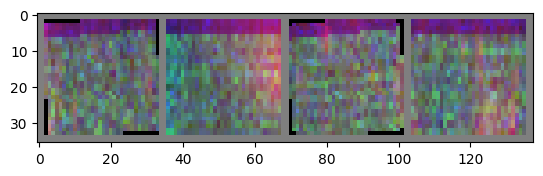

nonpulsar nonpulsar nonpulsar nonpulsar


In [ ]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

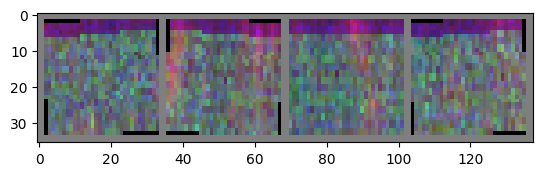

nonpulsar nonpulsar nonpulsar nonpulsar


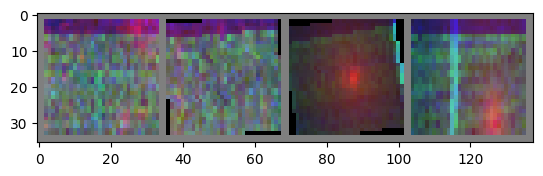

nonpulsar nonpulsar pulsar pulsar


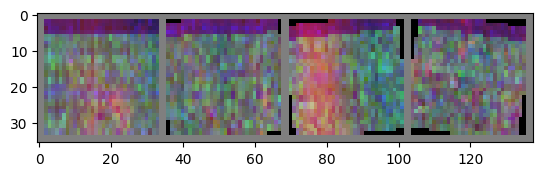

nonpulsar nonpulsar nonpulsar nonpulsar


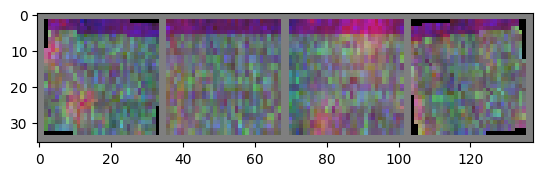

nonpulsar nonpulsar nonpulsar nonpulsar


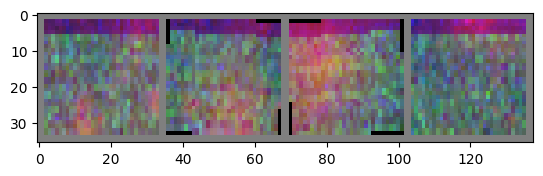

nonpulsar nonpulsar nonpulsar nonpulsar


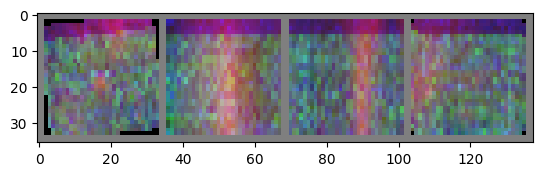

nonpulsar nonpulsar nonpulsar nonpulsar


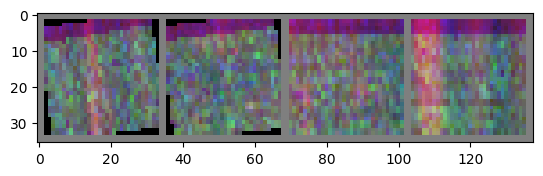

nonpulsar nonpulsar nonpulsar nonpulsar


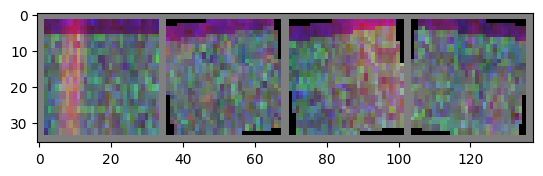

nonpulsar nonpulsar nonpulsar nonpulsar


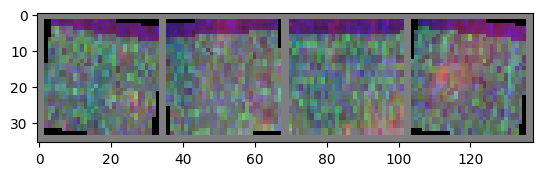

nonpulsar nonpulsar nonpulsar nonpulsar


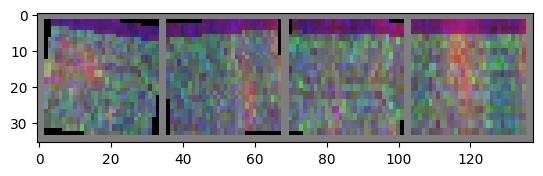

nonpulsar nonpulsar nonpulsar nonpulsar


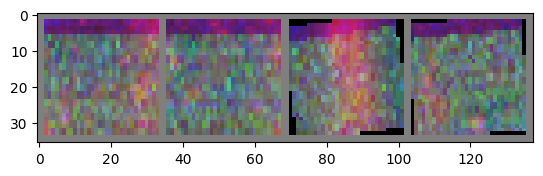

nonpulsar nonpulsar nonpulsar nonpulsar


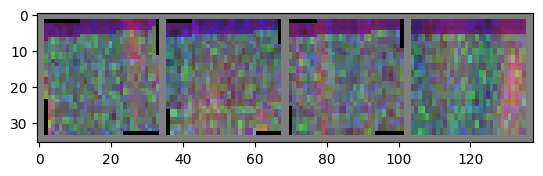

nonpulsar nonpulsar nonpulsar nonpulsar


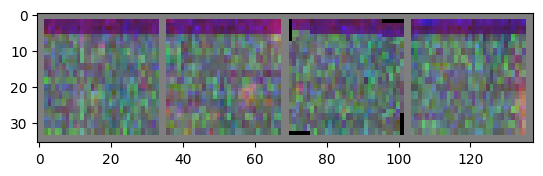

nonpulsar nonpulsar nonpulsar nonpulsar


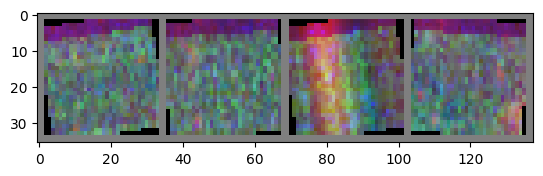

nonpulsar nonpulsar nonpulsar nonpulsar


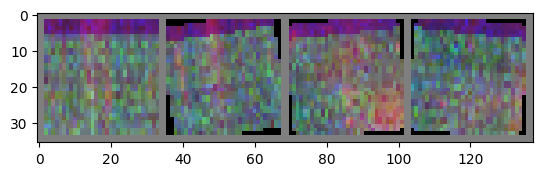

nonpulsar nonpulsar nonpulsar nonpulsar


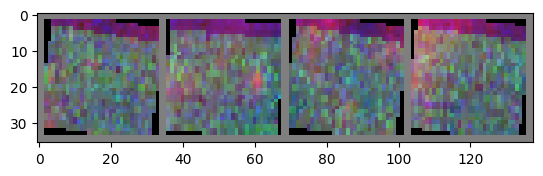

nonpulsar nonpulsar nonpulsar nonpulsar


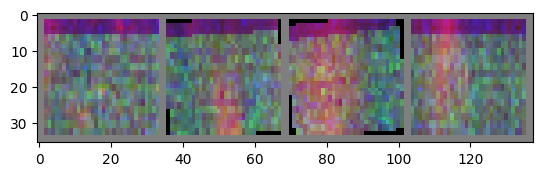

nonpulsar nonpulsar nonpulsar nonpulsar


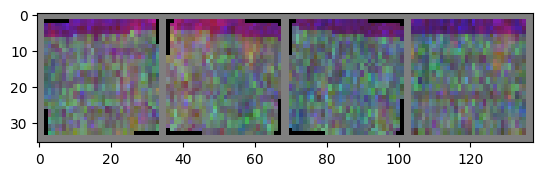

nonpulsar nonpulsar nonpulsar nonpulsar


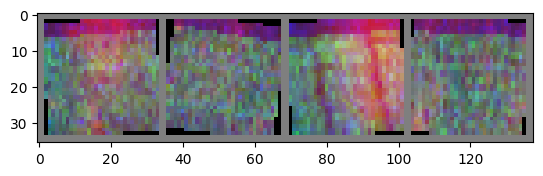

nonpulsar nonpulsar nonpulsar nonpulsar


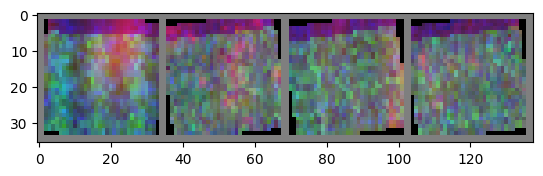

nonpulsar nonpulsar nonpulsar nonpulsar


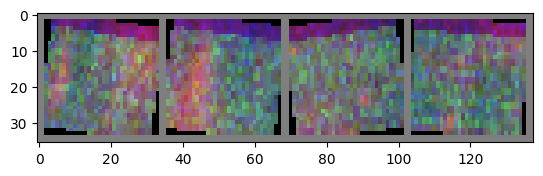

nonpulsar nonpulsar nonpulsar nonpulsar


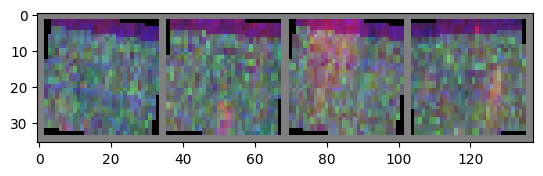

nonpulsar nonpulsar nonpulsar nonpulsar


In [ ]:
i=0
for image,label in trainloader:
  # plt.imshow(image[0].permute(1,2,0))
  imshow(torchvision.utils.make_grid(image))
  # plt.show()
  # print(label)
  print(' '.join('%5s' % classes[label[j]] for j in range(4)))
  if(i>20):
    break
  i=i+1

In [ ]:
class Pulsar(nn.Module):
    def __init__(self):
        super(Pulsar, self).__init__()
        self.Conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.Conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.Conv1(x)))
        x = self.pool(F.relu(self.Conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
from torchsummary import summary

In [ ]:
model=Pulsar()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Pulsar(
  (Conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 100]          40,100
            Linear-6                   [-1, 80]           8,080
            Linear-7                    [-1, 2]             162
Total params: 51,214
Trainable params: 51,214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.20
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

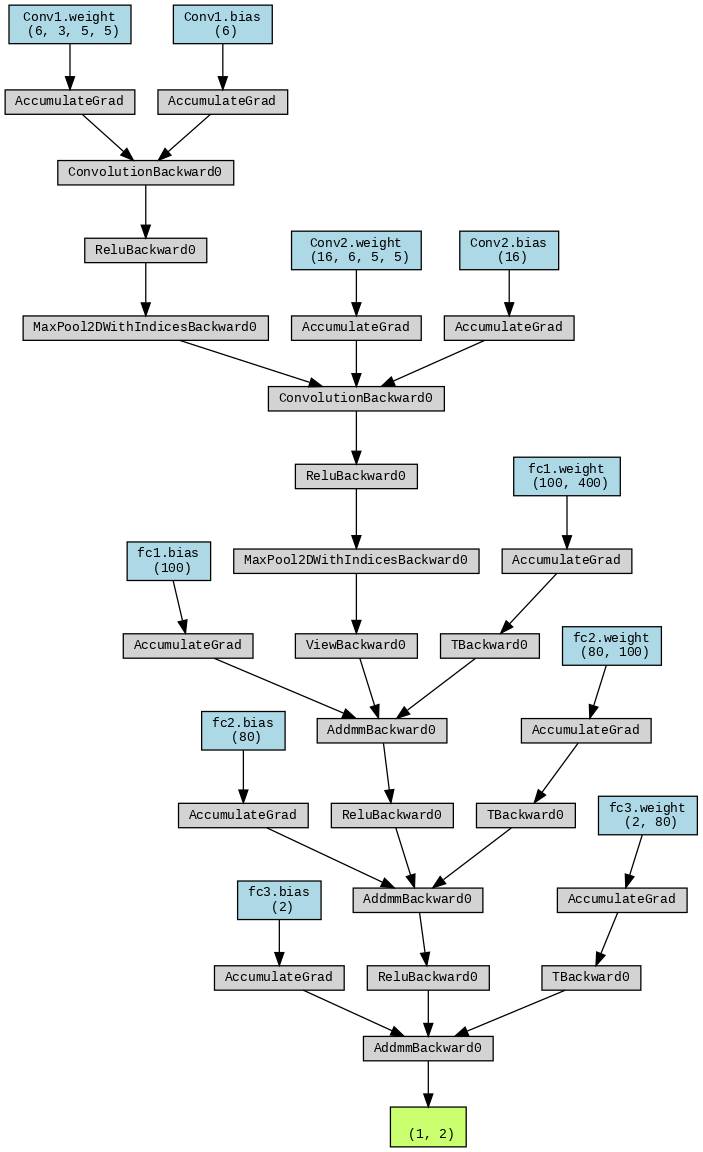

In [ ]:
from torchviz import make_dot
# Create a dummy input tensor with shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 32, 32).to(device)

# Pass the dummy input through the model to get the output
output = model(dummy_input)

# Generate a visualization of the model
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the visualization to a file
dot.format = 'png'
dot.render('pulsar_model')

# Display the visualization in Google Colab
from IPython.display import Image
Image('pulsar_model.png')

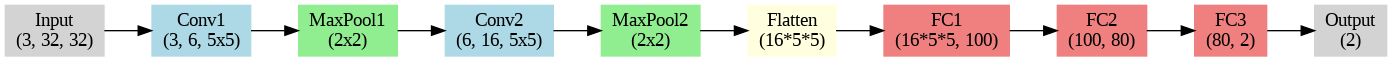

In [ ]:
from graphviz import Digraph

# Create a new Digraph
dot = Digraph(format='png')
dot.attr(rankdir='LR')

# Add nodes for each layer
dot.node('Input', 'Input\n(3, 32, 32)', shape='box', style='filled', color='lightgrey')
dot.node('Conv1', 'Conv1\n(3, 6, 5x5)', shape='box', style='filled', color='lightblue')
dot.node('Pool1', 'MaxPool1\n(2x2)', shape='box', style='filled', color='lightgreen')
dot.node('Conv2', 'Conv2\n(6, 16, 5x5)', shape='box', style='filled', color='lightblue')
dot.node('Pool2', 'MaxPool2\n(2x2)', shape='box', style='filled', color='lightgreen')
dot.node('Flatten', 'Flatten\n(16*5*5)', shape='box', style='filled', color='lightyellow')
dot.node('FC1', 'FC1\n(16*5*5, 100)', shape='box', style='filled', color='lightcoral')
dot.node('FC2', 'FC2\n(100, 80)', shape='box', style='filled', color='lightcoral')
dot.node('FC3', 'FC3\n(80, 2)', shape='box', style='filled', color='lightcoral')
dot.node('Output', 'Output\n(2)', shape='box', style='filled', color='lightgrey')

# Add edges to represent the flow
dot.edge('Input', 'Conv1')
dot.edge('Conv1', 'Pool1')
dot.edge('Pool1', 'Conv2')
dot.edge('Conv2', 'Pool2')
dot.edge('Pool2', 'Flatten')
dot.edge('Flatten', 'FC1')
dot.edge('FC1', 'FC2')
dot.edge('FC2', 'FC3')
dot.edge('FC3', 'Output')

# Render the graph
dot.render('/mnt/data/pulsar_model_viz')

# Display the visualization in Google Colab
from IPython.display import Image
Image('/mnt/data/pulsar_model_viz.png')


In [ ]:
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
nepoch = 15  # number of epochs

for epoch in range(nepoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.100
[1,  4000] loss: 0.039
[1,  6000] loss: 0.039
[1,  8000] loss: 0.036
[1, 10000] loss: 0.038
[1, 12000] loss: 0.035
[2,  2000] loss: 0.036
[2,  4000] loss: 0.033
[2,  6000] loss: 0.028
[2,  8000] loss: 0.031
[2, 10000] loss: 0.028
[2, 12000] loss: 0.026
[3,  2000] loss: 0.025
[3,  4000] loss: 0.026
[3,  6000] loss: 0.024
[3,  8000] loss: 0.022
[3, 10000] loss: 0.026
[3, 12000] loss: 0.025
[4,  2000] loss: 0.023
[4,  4000] loss: 0.022
[4,  6000] loss: 0.021
[4,  8000] loss: 0.020
[4, 10000] loss: 0.021
[4, 12000] loss: 0.025
[5,  2000] loss: 0.020
[5,  4000] loss: 0.023
[5,  6000] loss: 0.020
[5,  8000] loss: 0.024
[5, 10000] loss: 0.018
[5, 12000] loss: 0.020
[6,  2000] loss: 0.018
[6,  4000] loss: 0.017
[6,  6000] loss: 0.021
[6,  8000] loss: 0.018
[6, 10000] loss: 0.020
[6, 12000] loss: 0.022
[7,  2000] loss: 0.022
[7,  4000] loss: 0.021
[7,  6000] loss: 0.019
[7,  8000] loss: 0.015
[7, 10000] loss: 0.017
[7, 12000] loss: 0.015
[8,  2000] loss: 0.023
[8,  4000] 

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

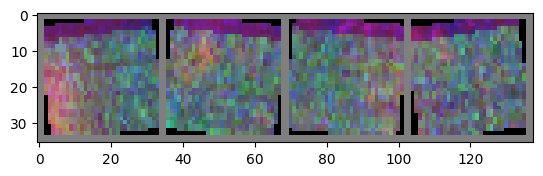

GroundTruth:  nonpulsar nonpulsar nonpulsar nonpulsar


In [ ]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = model(images)
outputs

tensor([[-4.8482,  5.1552],
        [-4.9661,  5.3392],
        [-5.3526,  5.6966],
        [-5.8363,  6.2120]], grad_fn=<AddmmBackward0>)

In [ ]:
_, predicted = torch.max(outputs, 1)
predicted
# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

tensor([1, 1, 1, 1])

In [ ]:
# Initialize variables to store true labels and predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy of the network on the 10000 test images: {accuracy * 100:.2f} %')

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy of the network on the 10000 test images: 1.99 %
Precision: 0.01
Recall: 0.50
F1 Score: 0.02


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


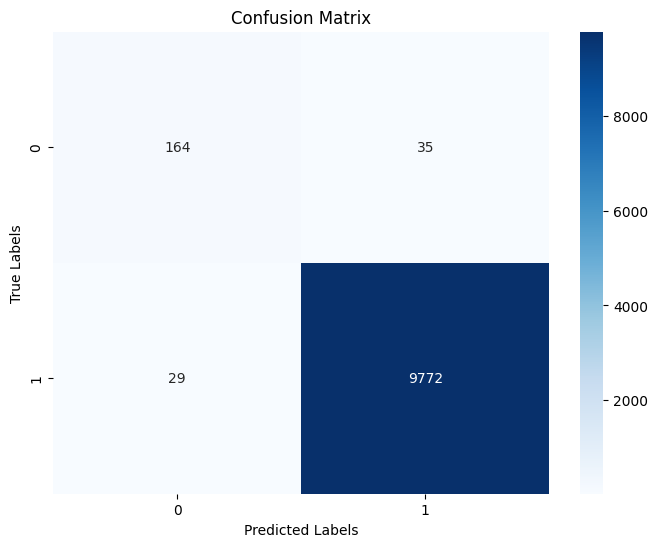

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# prompt: Mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: use torch.save to save the model to drive

# Assuming 'model' is your trained PyTorch model
model_save_path = '/content/drive/My Drive/pulsar_model.pth'
torch.save(model.state_dict(), model_save_path)


In [ ]:
# Load the model weights
model_path = '/content/drive/My Drive/pulsar_model.pth'  # Adjust the path to where you uploaded your model
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

Pulsar(
  (Conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=2, bias=True)
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


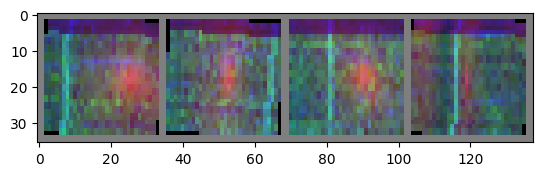

pulsar pulsar pulsar pulsar
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


In [ ]:
i=0
for image,label in testloader:
  print(i)
  if i== 20:
    image=imshow(torchvision.utils.make_grid(image))
    print(' '.join('%5s' % classes[label[j]] for j in range(4)))
  if(i>40):
    break
  i=i+1

In [ ]:
single_image = image[2]

# Add a batch dimension
single_image = single_image.unsqueeze(0)  # Now single_image has shape [1, 3, 32, 32]

# Make prediction
with torch.no_grad():
    output = model(single_image)
    _, predicted = torch.max(output, 1)
    print('Predicted class:', predicted.item())

Predicted class: 1


In [ ]:
_, predicted = torch.max(outputs, 1)
predicted
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))